In [180]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))

from utils import *

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

sns.set_style('ticks')

### Note 06/01/24:
We found that the provided Dragon_Descriptors.csv do not contain all CIDs used in the training mixtures. Below are the troubleshooting.

In [188]:
input_path = '../Data'

feature_file = 'Dragon_Descriptors.csv'
# features_file_2 =  'deepnose_features.npy'
CID_file = 'molecules_train_cid.npy'


# Read all copies, before and after correction; before was also downloaded from Dropbox.
mixture_file = 'Mixure_Definitions_Training_set.csv' 
mixture_file_bc = 'Mixure_Definitions_Training_set_before_correct.csv'
mixture_file_sn = 'Mixure_Definitions_Training_set_synapse.csv'

training_task_file = 'TrainingData_mixturedist.csv'
training_task_file_bc = 'TrainingData_mixturedist_before_correct.csv'
training_task_file_sn = 'TrainingData_mixturedist_synapse.csv'

# Dragon features
features = pd.read_csv(os.path.join(input_path, feature_file))
# features_2 = np.load(os.path.join(input_path, features_file_2))

features_CIDs = np.load(os.path.join(input_path, CID_file))


# Training dataframe, all 3 copies
training_set = pd.read_csv(os.path.join(input_path, training_task_file))
training_set_bc = pd.read_csv(os.path.join(input_path, training_task_file_bc))
training_set_sn = pd.read_csv(os.path.join(input_path, training_task_file_sn))

# Mapping helper files, all 3 copies
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))
mixtures_IDs_bc = pd.read_csv(os.path.join(input_path, mixture_file_bc))
mixtures_IDs_sn = pd.read_csv(os.path.join(input_path, mixture_file_sn))



In [189]:
# Dragon Descriptor Spreadsheet:
features.head()

,CID,complexity from pubmed,MW,AMW,Sv,Se,Sp,Si,Mv,Me,...,Psychotic-80,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50
0,126,5.263208,5.403263,4.683445,4.700571,4.747581,4.702233,4.759298,4.611818,4.615319,...,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517
1,176,4.875197,5.075549,4.677565,4.649024,4.686031,4.648536,4.693630,4.610755,4.615645,...,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517
2,177,4.703204,4.970230,4.666209,4.642158,4.673716,4.644170,4.682502,4.610536,4.615259,...,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517
3,180,4.605170,5.063164,4.661636,4.656766,4.700280,4.660974,4.713621,4.610456,4.615101,...,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517
4,196,5.365976,5.505982,4.675703,4.713962,4.793532,4.715145,4.811485,4.610904,4.615477,...,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517,4.60517


In [190]:
# Print feature dimension:
print('Total # of molecules with Dragon Descriptors provided:', features.shape[0])
print('Dragon descriptor dimension:', features.shape[1])

Total # of molecules with Dragon Descriptors provided: 575
Dragon descriptor dimension: 4870


The goal is to get the CIDs that are used in the mixtures, and order the feature space to a (# of used CID, # of descriptor) feature matrix, as we did for Deepnose features.

Below we found the different number of CIDs are implied in before and after correction: 

In [194]:
# Extract all columns for CIDs
CID_bag_bc = mixtures_IDs_bc.drop(['Dataset', 'Mixture Label'], axis=1)
CID_bag_sn = mixtures_IDs_sn.drop(['Dataset', 'Mixture Label'], axis=1)
CID_bag = mixtures_IDs.drop(['Dataset', 'Mixture Label'], axis=1)

In [195]:
CID_unique_bc = list(set(CID_bag_bc.values.flatten().tolist()))
CID_unique_bc.remove(0)
CID_unique_sn = list(set(CID_bag_sn.values.flatten().tolist()))
CID_unique_sn.remove(0)
CID_unique = list(set(CID_bag.values.flatten().tolist()))
CID_unique.remove(0)

In [196]:
print('Number of unique CIDs for the uncorrected mixture ID to CID mapping:', len(CID_unique_bc))
print('Number of unique CIDs for the uncorrected mixture ID to CID mapping:', len(CID_unique_sn))
print('Number of unique CIDs for the corrected mixture ID to CID mapping:', len(CID_unique))

Number of unique CIDs for the uncorrected mixture ID to CID mapping: 231
Number of unique CIDs for the uncorrected mixture ID to CID mapping: 165
Number of unique CIDs for the corrected mixture ID to CID mapping: 162


In [199]:
np.save('../Output/uniqueCIDs_before-correction.npy', CID_unique_bc)
np.save('../Output/uniqueCIDs_synapse.npy', CID_unique_sn)
np.save('../Output/uniqueCIDs_after-correction.npy', CID_unique)

In [200]:
print('Number of shared correct v.s before correct:' ,len(set(CID_unique) & set(CID_unique_bc)))
print('Number of shared correct v.s from synapse:' ,len(set(CID_unique) & set(CID_unique_sn)))

Number of shared correct v.s before correct: 153
Number of shared correct v.s from synapse: 153


Lets try to extract all CIDs Dragon Descriptors after correction first

In [159]:
# Identify columns with the same value across all rows (this has nothing to do with the CID troubleshooting)
columns_to_drop = []
for column in features.columns:
    if len(features[column].unique()) == 1:
        columns_to_drop.append(column)

print("Number of columns to be dropped:", len(columns_to_drop))

features = features.drop(columns=columns_to_drop)

# Print reduced shape:
print("Updated DataFrame shape:", features.shape)

# columns to be dropped: 1752
Updated DataFrame shape: (575, 3118)


We only found 154/162 features in the Dragon Descriptor spreadsheet:

In [161]:
# molecules_train_cid.npy contains the same number of unique CIDs as the corrected file:
CID_unique.remove(0) # unique values includes zero, remove it
set(features_CIDs) == set(CID_unique)

True

In [162]:
# Create df with rows matching the 'CID' values in 'features_CIDs'
new_features_df = features[features['CID'].isin(CID_unique)]
print('Total number of CIDs in corrected mixture file found in the Dragon Descriptor df:', len(new_features_df))

Total number of CIDs in corrected mixture file found in the Dragon Descriptor df: 154


-----

### Visualize distribution of dragon features:

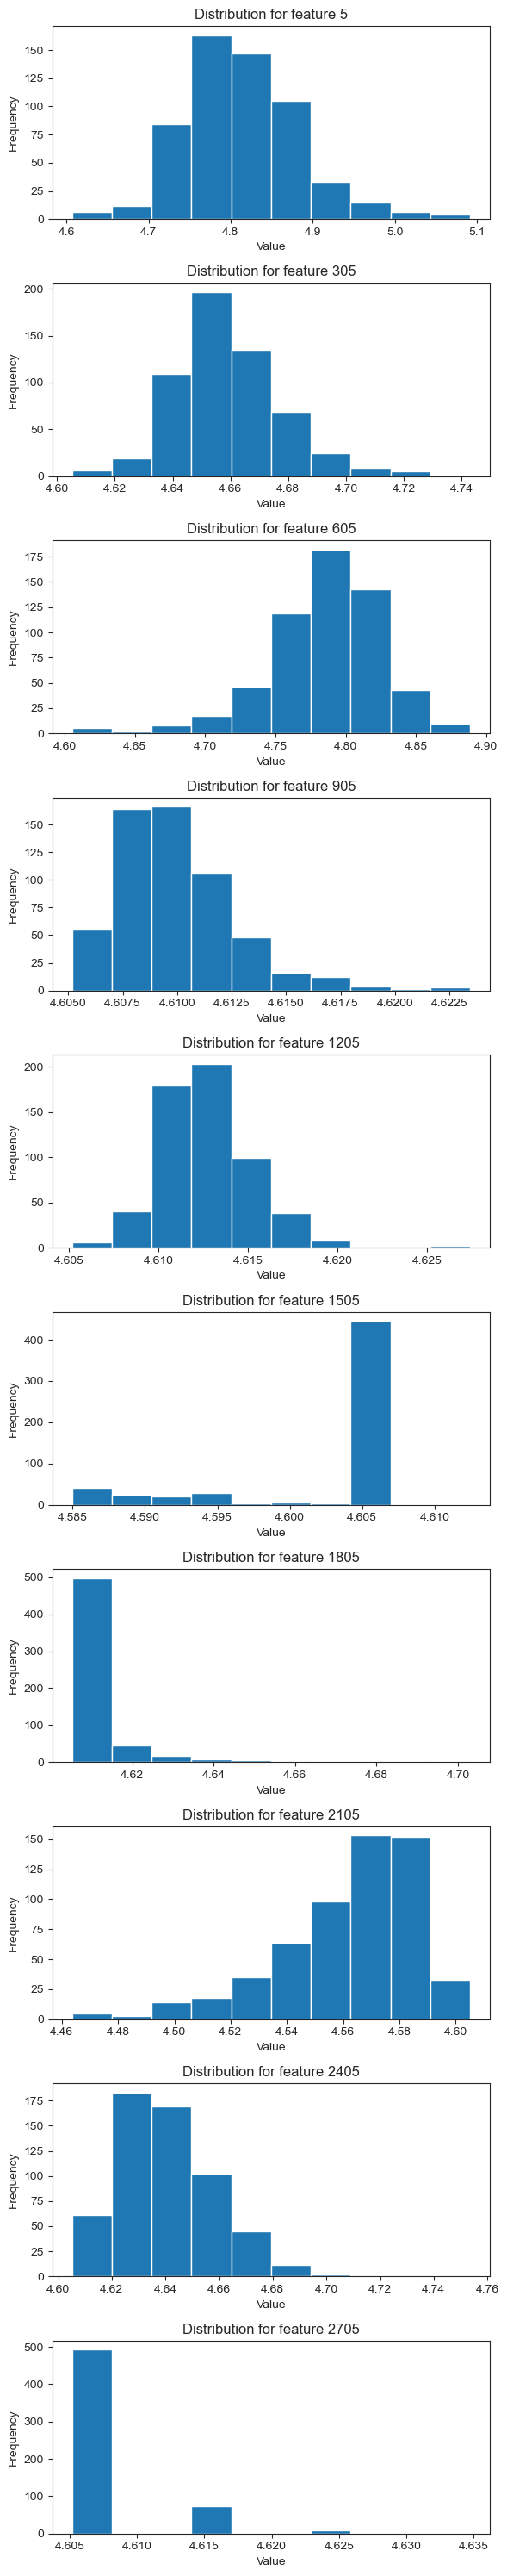

In [52]:
selected_n = list(range(5, 3000, 300))

# Create a figure and subplots
fig, axs = plt.subplots(len(selected_n), 1, figsize=(6, 3*len(selected_n)))

# Plot the distributions on separate subplots
for i, n in enumerate(selected_n):
    axs[i].hist(features.to_numpy()[:, n])
    axs[i].set_title(f"Distribution for feature {n}")
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Frequency")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()